In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GaussianNoise
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [27]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [28]:
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

x_train shape: (60000, 28, 28), y_train shape: (60000,)


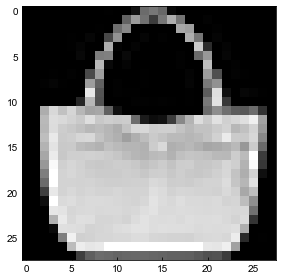

In [29]:
plt.imshow(x_train[100], cmap='gray')

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [49]:
x_train = x_train.reshape(len(x_train), 28*28)
x_val = x_val.reshape(len(x_val), 28*28)
x_test = x_test.reshape(len(x_test), 28*28)

In [32]:
print(x_train.shape)
print(x_val.shape)

(54000, 784)
(6000, 784)


In [50]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.
x_test = x_test.astype('float32')/255.

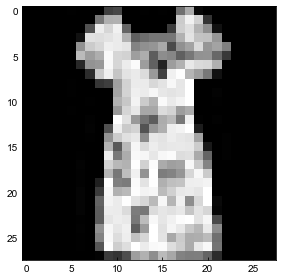

In [34]:
plt.imshow(x_train[10].reshape(28,28), cmap='gray')

In [35]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [36]:
# autoencoder
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim)/encoding_dim
print("Compression factor: {}".format(compression_factor))

autoencoder = Sequential()
autoencoder.add(
    Dense(units=encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(units=input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 24.5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [46]:
# encoder
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [37]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])

In [39]:
early_stopping = EarlyStopping()
hist = autoencoder.fit(x_train, x_train, epochs=100, batch_size=256,
                 validation_data=(x_val, x_val), callbacks=[early_stopping])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 1s 28us/step - loss: 0.4254 - acc: 0.4807 - val_loss: 0.3495 - val_acc: 0.4993
Epoch 2/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.3324 - acc: 0.5022 - val_loss: 0.3213 - val_acc: 0.5038
Epoch 3/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.3150 - acc: 0.5050 - val_loss: 0.3098 - val_acc: 0.5059
Epoch 4/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.3058 - acc: 0.5062 - val_loss: 0.3020 - val_acc: 0.5065
Epoch 5/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.2994 - acc: 0.5069 - val_loss: 0.2966 - val_acc: 0.5074
Epoch 6/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.2944 - acc: 0.5075 - val_loss: 0.2925 - val_acc: 0.5075
Epoch 7/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.2912 - acc: 0.5078 - val_loss: 0.2897 - v

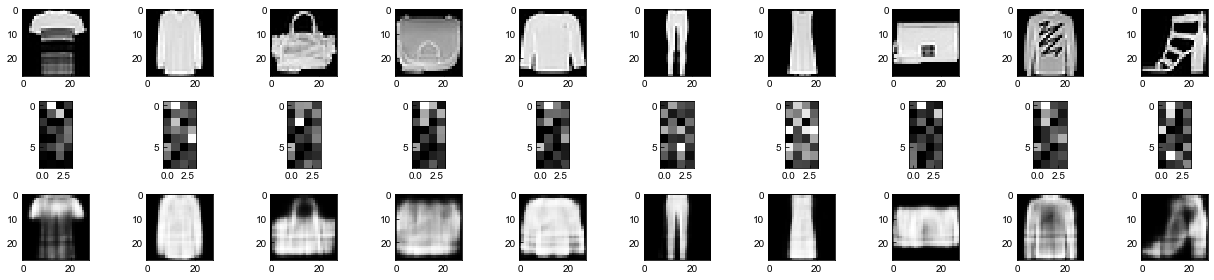

In [55]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i+1)
    plt.imshow(x_test[image_idx].reshape(28,28))
    plt.gray()
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(encoded_imgs[image_idx].reshape(8,4))
    plt.gray()
    
    # plot decoded image
    ax = plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(decoded_imgs[image_idx].reshape(28,28))
    plt.gray()

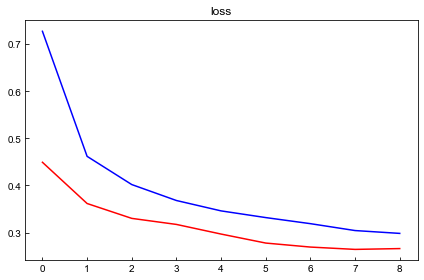

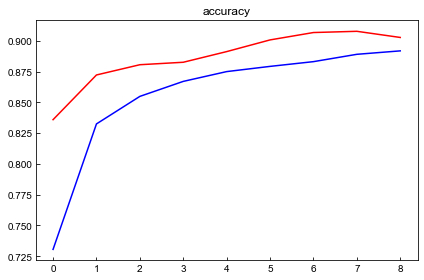

In [21]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('loss')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.title('accuracy')
plt.show()

In [22]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
pprint(cm)

array([[485,   3,  15,  21,   2,   0,  71,   0,   3,   0],
       [  0, 579,   0,   7,   0,   0,   1,   0,   0,   0],
       [  7,   0, 467,   4,  55,   0,  45,   0,   1,   0],
       [  6,   7,   4, 585,  14,   0,  16,   0,   1,   0],
       [  0,   0,  15,  16, 538,   0,  48,   0,   0,   0],
       [  0,   0,   0,   0,   0, 611,   0,  16,   0,   3],
       [ 45,   0,  30,  20,  40,   0, 448,   0,   5,   0],
       [  0,   0,   0,   0,   0,   5,   0, 593,   1,   6],
       [  0,   0,   1,   2,   1,   0,   4,   2, 543,   0],
       [  0,   0,   0,   0,   0,   4,   0,  35,   1, 568]], dtype=int64)


In [87]:
y_hat = model.predict(df_test.values, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

In [88]:
with open('submission.csv', 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))